# 02: Plotting Spatial Distributions

The last tutorial ended with a simple quick-look plot for a geographic variable, AOD. In this tutorial, we begin to explore how to make prettier plots, as well as how to isolate specific periods and regions using [xarray](https://xarray.pydata.org).

First import the modules:

In [1]:
import numpy as np
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import cartopy.util as cputil
import colormaps

import warnings
warnings.filterwarnings('ignore') 

And then read in the data:

In [2]:
ncdf = xr.open_dataset('cams_compositionreanalysis_2003-2024.1m.nc')
aod = ncdf['aod550']

# you can also write this in one line as
# aod = xr.open_dataset('cams_compositionreanalysis_2003-2024.1m.nc')['aod550']

To make a nicer plot, we can add some formatting. Explanations for each line are provided as comments in the code block below. The most important new tool here is [cartopy](https://scitools.org.uk/cartopy/docs/latest/index.html), which is now the standard module for mapping geospatial variables in python. 
- [Getting started with cartopy](https://scitools.org.uk/cartopy/docs/latest/getting_started/index.html)

The following code block also includes examples of three core python data structures: [tuples](https://www.w3schools.com/python/python_tuples.asp), [lists](https://www.w3schools.com/python/python_lists.asp), and [dictionaries](https://www.w3schools.com/python/python_dictionaries.asp).
- [Python core data structures, including dictionaries](https://docs.python.org/3/tutorial/datastructures.html)

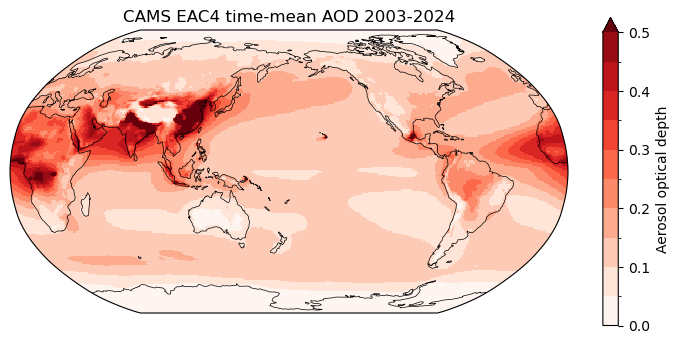

In [3]:
fig = plt.figure(figsize=(9,4))   # Figure size as a tuple in width, height; can also specify dpi and other features
axs = fig.add_subplot(111, projection=ccrs.Robinson(central_longitude=180)) # here we need a cartopy GeoAxes to plot the map

# The following is a python 'dictionary' {} that defines keywords to control the colorbar:
cbkws = {'label': 'Aerosol optical depth', 'orientation': 'vertical', 'ticks': [0, 0.1, 0.2, 0.3, 0.4, 0.5]} # note: last is a list []
# Define some keywords to control the plot:
clrs = plt.cm.Reds  # included in matplotlib.pyplot; see https://matplotlib.org/stable/users/explain/colors/colormaps.html
clev = np.linspace(0, 0.5, 11)    # creates an evenly spaced list of numbers between 225 and 305 with 21 steps
kwrgs = {'cmap': clrs, 'levels': clev, 'extend': 'max', 'transform': ccrs.PlateCarree(), 'add_colorbar': True, 'cbar_kwargs': cbkws}

# don't forget to average over time!
aod.mean('time').plot(ax=axs, **kwrgs) # ** indicates a dictionary expansions; especially useful when making lots of similar plots
# add some coastlines
axs.coastlines(color='k', lw=0.5) # black, with a narrow line
# add a title
axs.set_title('CAMS EAC4 time-mean AOD 2003-2024')

# these two steps remove the text output
plt.show()

Note the use of transform in the keywords dictionary kwrgs. When working with cartopy, the most common errors arise from leaving out [transform, projection, or crs keywords](https://scitools.org.uk/cartopy/docs/latest/tutorials/understanding_transform.html), or making a mistake in how these keywords are specified. If data isn't showing up on your map as you expect, this is the first place to look!

Although cartopy is not always the most intuitive to use, it is very flexible. Below we recenter the plot on the Atlantic, change the color table, and plot the distribution as filled contours instead of filled grid cells ([pcolormesh](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.pcolormesh.html), the default plot type for geospatial data in xarray).
- [Plotting in xarray](https://docs.xarray.dev/en/stable/user-guide/plotting.html)

In [4]:
# First we should add a cyclic point to fill the gap at 0° longitude
cyclic_aod, cyclic_lon = cputil.add_cyclic_point(aod, coord=aod.lon)
coords = {dim: aod[dim].values for dim in list(aod.dims) if dim != 'lon'}
coords['lon'] = cyclic_lon
cyclic_aod = xr.DataArray(cyclic_aod, coords=coords, dims=list(aod.dims))

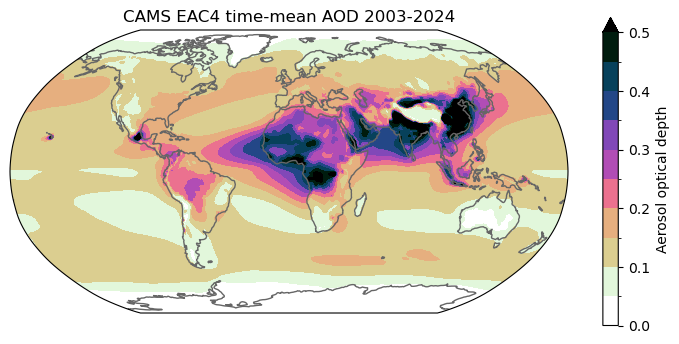

In [5]:
fig = plt.figure(figsize=(9,4))
axs = fig.add_subplot(111, projection=ccrs.Robinson(central_longitude=0)) # Recenter on the Atlantic

cbkws = {'label': 'Aerosol optical depth', 'orientation': 'vertical', 'ticks': [0, 0.1, 0.2, 0.3, 0.4, 0.5]}
clrs = colormaps.cubehelix2_16_r  # https://pratiman-91.github.io/colormaps/docs/Other#cubehelix-schemes
clev = np.linspace(0, 0.5, 11)
kwrgs = {'cmap': clrs, 'levels': clev, 'extend': 'max', 'transform': ccrs.PlateCarree(), 'add_colorbar': True, 'cbar_kwargs': cbkws}

# change the plot type from filled boxes to contours
cyclic_aod.mean('time').plot.contourf(ax=axs, **kwrgs)
axs.coastlines(color='#666', lw=1) # grey, with a thicker line
axs.set_title('CAMS EAC4 time-mean AOD 2003-2024')

plt.show()

Similarly, we can use xarray to select the season and then average.
- [Time series in xarray](https://docs.xarray.dev/en/stable/user-guide/time-series.html)

The following block of code shows two different ways to achieve this.

In [6]:
aod_son = aod.isel(time=(aod.time.dt.season == 'SON')).mean('time')
aod_ssn = cyclic_aod.groupby('time.season').mean('time')
aod_ssn.season

<xarray.DataArray 'season' (season: 4)> Size: 32B
array(['DJF', 'JJA', 'MAM', 'SON'], dtype=object)
Coordinates:
  * season   (season) object 32B 'DJF' 'JJA' 'MAM' 'SON'

Here we plot the difference in AOD at 550nm between boreal autumn (SON) and boreal spring (MAM):

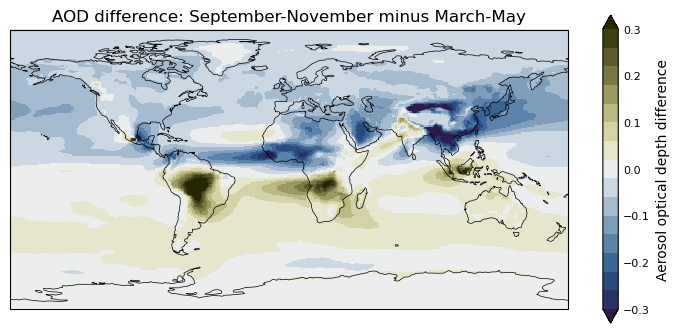

In [7]:
fig = plt.figure(figsize=(9,4))
axs = fig.add_subplot(111, projection=ccrs.PlateCarree()) # Recenter on the Atlantic

cbkws = {'label': 'Aerosol optical depth difference', 'orientation': 'vertical', 'ticks': [-0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3]}
clrs = colormaps.broc  # https://pratiman-91.github.io/colormaps/docs/Diverging
clev = np.linspace(-0.3, 0.3, 16)
kwrgs = {'cmap': clrs, 'levels': clev, 'extend': 'both', 'transform': ccrs.PlateCarree(), 'add_colorbar': True, 'cbar_kwargs': cbkws}

# change the plot type from filled boxes to contours
aod_dff = aod_ssn.sel(season='SON') - aod_ssn.sel(season='MAM')
c = aod_dff.plot(ax=axs, **kwrgs)
axs.coastlines(color='k', lw=0.5)
axs.set_title('AOD difference: September-November minus March-May') # new title
# we can also change the colorbar appearance by using the plot object (stored as c above)
c.colorbar.ax.tick_params(labelsize=8, length=0, which='both')

plt.show()

We can also plot an individual region, along with other features like national borders and target locations.

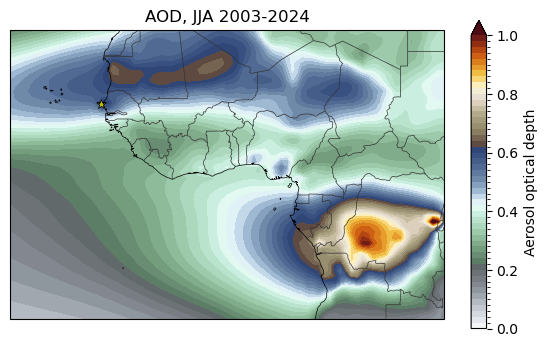

In [8]:
fig = plt.figure(figsize=(7,4))
axs = fig.add_subplot(111, projection=ccrs.PlateCarree()) # Recenter on the Atlantic

cbkws = {'label': 'Aerosol optical depth', 'orientation': 'vertical', 'ticks': [0, 0.2, 0.4, 0.6, 0.8, 1]}
clrs = colormaps.hier5  # https://pratiman-91.github.io/colormaps/docs/Other#cubehelix-schemes
clev = np.linspace(0, 1, 51)
kwrgs = {'cmap': clrs, 'levels': clev, 'extend': 'max', 'transform': ccrs.PlateCarree(), 'add_colorbar': True, 'cbar_kwargs': cbkws}

# change the plot type from filled boxes to contours
aod_ssn.sel(season='JJA').plot.contourf(ax=axs, **kwrgs)

axs.coastlines(color='k', lw=0.5)
axs.add_feature(cfeat.BORDERS, color='#333', lw=0.5)
axs.set_title('AOD, JJA 2003-2024')
c.colorbar.ax.tick_params(labelsize=8, length=0, which='both')

# to plot just a specific region
axs.set_extent([-30, 30, -15, 25], crs=ccrs.PlateCarree())

# To add standard plot elements with lat-lon coordinates (here a 
#   star to mark Dakar), we should use a cartopy transform
axs.scatter(-17.4, 14.7, marker='*', color='y', edgecolor='k', lw=0.5,
            s=50, zorder=10, transform=ccrs.PlateCarree())

plt.show()

Similarly, we can use xarray to evaluate the change in AOD over a period (here a simple difference; see subsequent tutorials and exercises for trends), or choose a different perspective or style for the plot.
- [List of cartopy projections](https://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html)

In [9]:
aod_mid = aod.sel(time=(aod.time.dt.season=='SON')).sel(time=slice('2020', '2024')).mean('time')
aod_end = aod.sel(time=(aod.time.dt.season=='SON')).sel(time=slice('2005', '2009')).mean('time')
aod_dff = aod_end - aod_mid

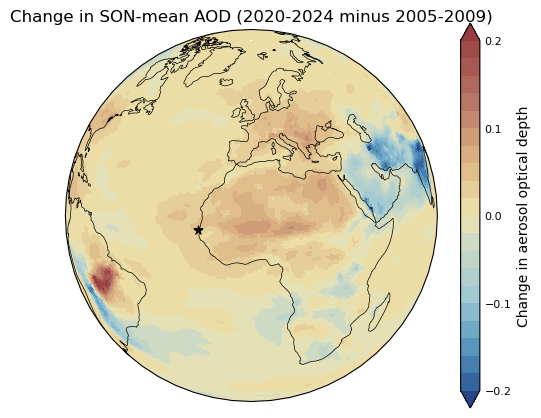

In [10]:
fig = plt.figure(figsize=(6,5))
axs = fig.add_subplot(111, projection=ccrs.Orthographic(central_longitude=0.0, central_latitude=20))
clrs = colormaps.w5m4  # https://pratiman-91.github.io/colormaps/docs/Diverging
cbkws = {'label': 'Change in aerosol optical depth', 'orientation': 'vertical', 'ticks': [-0.2, -0.1, 0, 0.1, 0.2]}
kwrgs = {'cmap': clrs, 'levels': np.linspace(-0.2,0.2,21), 'extend': 'both', 'transform': ccrs.PlateCarree(), 'add_colorbar': True, 'cbar_kwargs': cbkws}

c = aod_dff.plot(ax=axs, **kwrgs)
axs.coastlines(color='k', lw=0.5, zorder=3)
axs.set_title('Change in SON-mean AOD (2020-2024 minus 2005-2009)')
c.colorbar.ax.tick_params(labelsize=8, length=0, which='both')

axs.scatter(-17.4, 14.7, marker='*', color='k', edgecolor='k', lw=0.5,
            s=50, zorder=10, transform=ccrs.PlateCarree())

plt.show()